```
This software is part of GPU Ocean. 

Copyright (C) 2022 SINTEF Digital

Minimal example for running the simplified ocean model from 
real-world initial conditions. Including plotting.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Simple minimal script for running a real-world simulation 

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from netCDF4 import Dataset
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
plt.rcParams["animation.html"] = "jshtml"
mpl.rcParams['figure.facecolor'] = 'white'

In [16]:
from gpuocean.SWEsimulators import CDKLM16
from gpuocean.utils import Common, IPythonMagic, NetCDFInitialization, OceanographicUtilities
from gpuocean.drifters import GPUDrifterCollection

In [3]:
%cuda_context_handler gpu_ctx

### Plotting functionality

In [51]:
def plotSolution(fig, sim, comment="",
                 eta_max=2, hu_max=50, 
                 ax=None, sp=None):

    eta, hu, hv = sim.download(interior_domain_only=True)
    dx, dy, t = sim.dx, sim.dy, sim.t
    
    from datetime import timedelta
    fig.suptitle("Time = {:0>8} ({:s})".format(str(timedelta(seconds=int(t))), comment), 
                 fontsize=18,
                 horizontalalignment='left')
    
    ny, nx = eta.shape
    domain_extent = [0, nx*dx, 0, ny*dy]
   
    if (ax is None):
        ax = [None]*3
        sp = [None]*3
        
        ax[0] = plt.subplot(1, 3, 1)
        sp[0] = ax[0].imshow(eta, interpolation="none", origin='lower', 
                             cmap=plt.cm.BrBG, vmin=-eta_max, vmax=eta_max, 
                             extent=domain_extent)
        plt.colorbar(sp[0], shrink=0.9)
        plt.axis('image')
        plt.title("$\eta{}$")
        
        ax[1] = plt.subplot(1, 3, 2)
        sp[1] = ax[1].imshow(hu, interpolation="none", origin='lower', 
                            cmap=plt.cm.coolwarm, vmin=-hu_max, vmax=hu_max, 
                            extent=domain_extent)
        plt.colorbar(sp[1], shrink=0.9)
        plt.axis('image')
        plt.title("$hu$")

        ax[2] = plt.subplot(1, 3, 3)
        sp[2] = ax[2].imshow(hv, interpolation="none", origin='lower', 
                             cmap=plt.cm.coolwarm, vmin=-hu_max, vmax=hu_max, 
                             extent=domain_extent)
        plt.colorbar(sp[2], shrink=0.9)
        plt.axis('image')
        plt.title("$hv$")
            
    else:        
        #Update plots
        fig.sca(ax[0])
        sp[0].set_data(eta)
        
        fig.sca(ax[1])
        sp[1].set_data(hu)
        
        fig.sca(ax[2])
        sp[2].set_data(hv)
        
    return ax, sp


def sim_animation(sim, T, anim_dt, hu_max=20.0, eta_max=0.5, comment=""):
    """
    Creates an animation of the simulator based on T frames, with frames sub_dt*sim.dt appart.
    """

    
    #Create figure and plot initial conditions
    fig = plt.figure(figsize=(14, 4))
    ax, sp = plotSolution(fig, sim, comment=comment,
                          eta_max=eta_max, hu_max=hu_max)
    #Helper function which simulates and plots the solution
    def animate(i):
        if (i>0):
            t = sim.step(anim_dt)
        else:
            t = 0.0

        plotSolution(fig, sim, comment=comment, ax=ax, sp=sp)
        print(".", end='')
        
    #Matplotlib for creating an animation
    anim = animation.FuncAnimation(fig, animate, range(T), interval=100)
    plt.close(fig)
    return anim

def imshow3(eta, hu, hv, interpolation="None", title=None, figsize=(12,3), interior=False, range_eta=None, range_huv=None):
    fig, axs = plt.subplots(1,3, figsize=figsize)
    if range_eta is None:
        range_eta = np.max(np.abs(eta))
    if range_huv is None:
        range_huv = max(np.max(np.abs(hu)), np.max(np.abs(hv)))
    
    if interior:
        eta_im = axs[0].imshow(eta[2:-2,2:-2], interpolation=interpolation, origin='lower', )
    else:
        eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', )
    axs[0].set_title("$\eta$")
    plt.colorbar(eta_im, ax=axs[0])
    if interior:
        hu_im = axs[1].imshow(hu[2:-2,2:-2], interpolation=interpolation, origin='lower',)
    else:
        hu_im = axs[1].imshow(hu, interpolation=interpolation, origin='lower', )
    axs[1].set_title("$hu$")
    plt.colorbar(hu_im, ax=axs[1])
    if interior:
        hv_im = axs[2].imshow(hv[2:-2,2:-2], interpolation=interpolation, origin='lower', )
    else:
        hv_im = axs[2].imshow(hv, interpolation=interpolation, origin='lower',)
    axs[2].set_title("$hv$")
    plt.colorbar(hv_im, ax=axs[2])
    if title is not None:
        plt.suptitle(title)
    plt.tight_layout()

### Select url for initial conditions, domain, and simulate!

In [5]:
source_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

casename = 'lofoten'

case_info = NetCDFInitialization.getCaseLocation(casename)
print(case_info["name"])

data_args = NetCDFInitialization.getInitialConditions(source_url,case_info["x0"], case_info["x1"], case_info["y0"], case_info["y1"], download_data=False)

lofoten


In [6]:
sim = CDKLM16.CDKLM16(gpu_ctx, dt=0.0, write_netcdf=False,  **NetCDFInitialization.removeMetadata(data_args))

C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\SWEsimulators\CDKLM16.py:220: UserWarning: The CUDA compiler succeeded, but said the following:
C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\gpu_kernels\CDKLM16_kernel.cu(944): warning: variable "u" was declared but never referenced

C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\gpu_kernels\CDKLM16_kernel.cu(945): warning: variable "v" was declared but never referenced

kernel.cu

  jit_compile_args={
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [25]:
data_args["ny"]

296

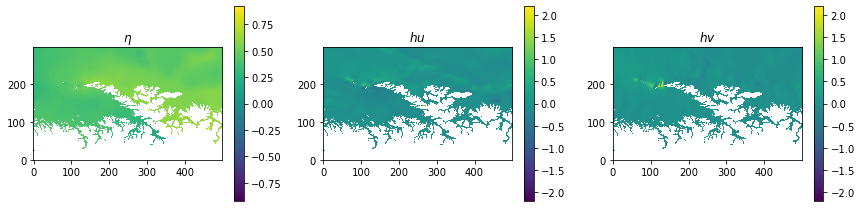

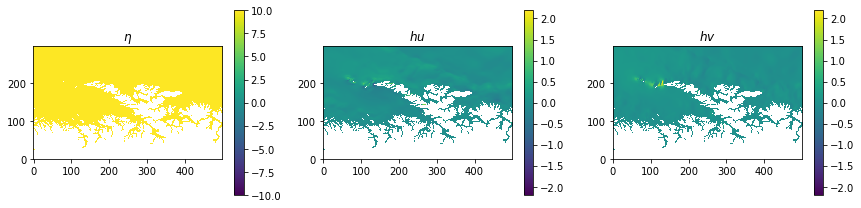

In [12]:
eta, hu, hv = sim.download()
_, hm = sim.downloadBathymetry()
u = hu / (eta + hm)
v = hv / (eta + hm)
imshow3(eta, u, v)

h0 = np.ones_like(eta)*10
imshow3(h0, u, v)


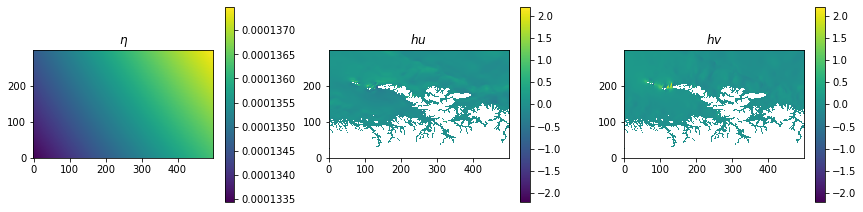

In [23]:
[f, beta] = OceanographicUtilities.calcCoriolisParams(data_args['latitude'])
imshow3(f, u, v)


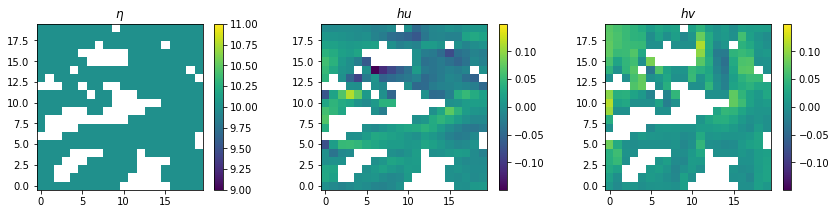

In [31]:
y0, y1, x0, x1= 90, 110, 0, 20

h0small = h0[y0:y1, x0:x1]
usmall = u[y0:y1, x0:x1]
vsmall = v[y0:y1, x0:x1]
fsmall = f[y0:y1, x0:x1]
imshow3(h0small, usmall, vsmall)


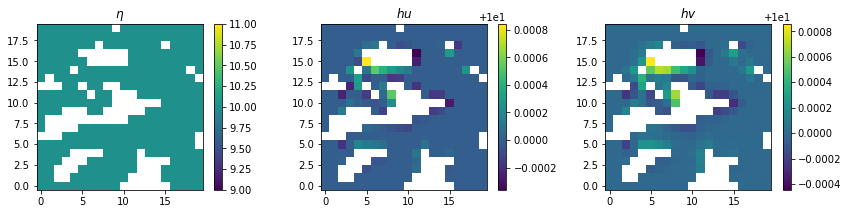

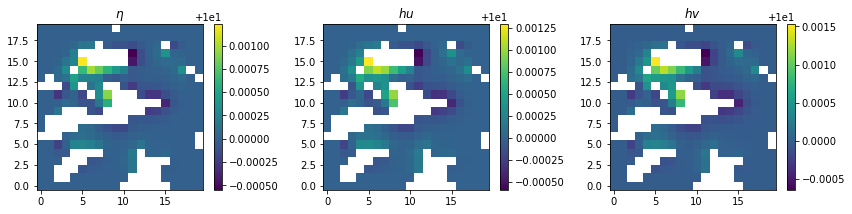

In [63]:

def update_h(h0, u, v, f, g, dx=800, dy=800, x_dir=True, y_dir=True):
    h1 = np.zeros_like(h0)
    h1[:,:] = h0[:, :]

    ny, nx = h0.shape

    for y in range(2, ny-2):
        for x in range(2, nx-2):
            if not h0.mask[y, x]:
                # h0 is wet
                newh = 0
                num_wet_neighbours = 0
                
                if y_dir:
                    if not h0.mask[y-1, x]: 
                        # south is wet
                        num_wet_neighbours += 1
                        newh += h0[y-1, x] - (f[y,x]*u[y,x]*dy/g)

                    if not h0.mask[y+1, x]:
                        # north is wet
                        num_wet_neighbours += 1
                        newh += h0[y+1, x] + (f[y,x]*u[y,x]*dy/g)
                
                if x_dir:
                    if not h0.mask[y, x-1]:
                        # west is wet
                        num_wet_neighbours += 1
                        newh += h0[y, x-1] + (f[y,x]*v[y,x]*dx/g)
                    
                    if not h0.mask[y, x+1]:
                        # east is wet
                        num_wet_neighbours += 1
                        newh += h0[y, x+1] - (f[y,x]*v[y,x]*dx/g)
                
                if num_wet_neighbours > 0:
                    h1[y, x] = newh/num_wet_neighbours
                else:
                    h1[y, x] = h1[y, x]


    return h1


h1small = update_h(h0small, usmall, vsmall, fsmall, 9.81)
h2small = update_h(h1small, usmall, vsmall, fsmall, 9.81)

imshow3(h0small, h1small, h2small)

h3small = update_h(h2small, usmall, vsmall, fsmall, 9.81)
h4small = update_h(h3small, usmall, vsmall, fsmall, 9.81)
h5small = update_h(h4small, usmall, vsmall, fsmall, 9.81)

imshow3(h3small, h4small, h5small)









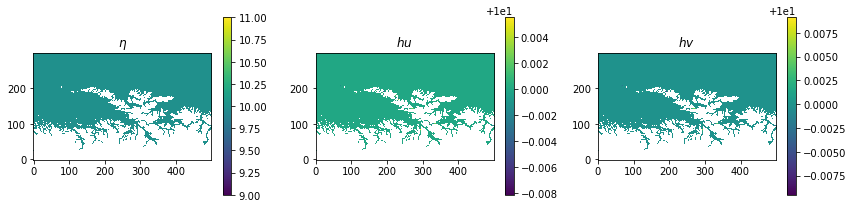

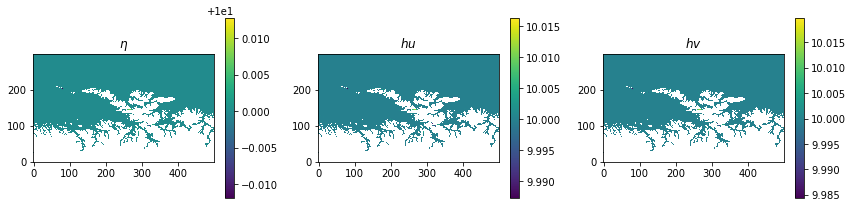

In [53]:

h1 = update_h(h0, u, v, f, 9.81)
h2 = update_h(h1, u, v, f, 9.81)

imshow3(h0, h1, h2)

h3 = update_h(h2, u, v, f, 9.81)
h4 = update_h(h3, u, v, f, 9.81)
h5 = update_h(h4, u, v, f, 9.81)


imshow3(h3, h4, h5)



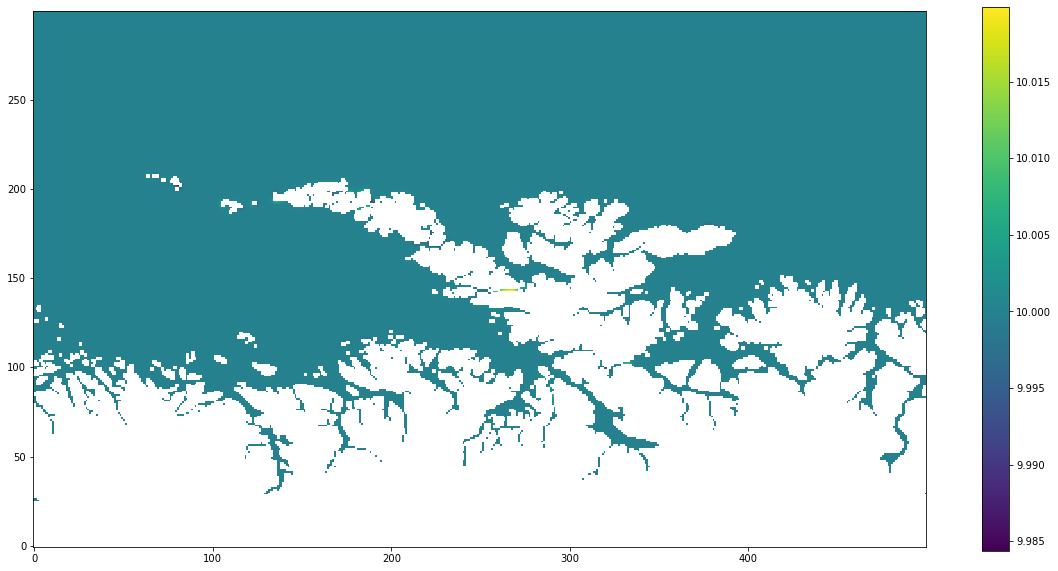

In [56]:
fig = plt.figure(figsize=(20, 10))
plt.imshow(h5, origin='lower')
plt.colorbar()

In [68]:
h1 = np.ones_like(h0)*10
for i in range(10):
    h1 = update_h(h1, u, v, f, 0.01, x_dir=True, y_dir=False)
    h1 = update_h(h1, u, v, f, 0.01, x_dir=False, y_dir=True)
    



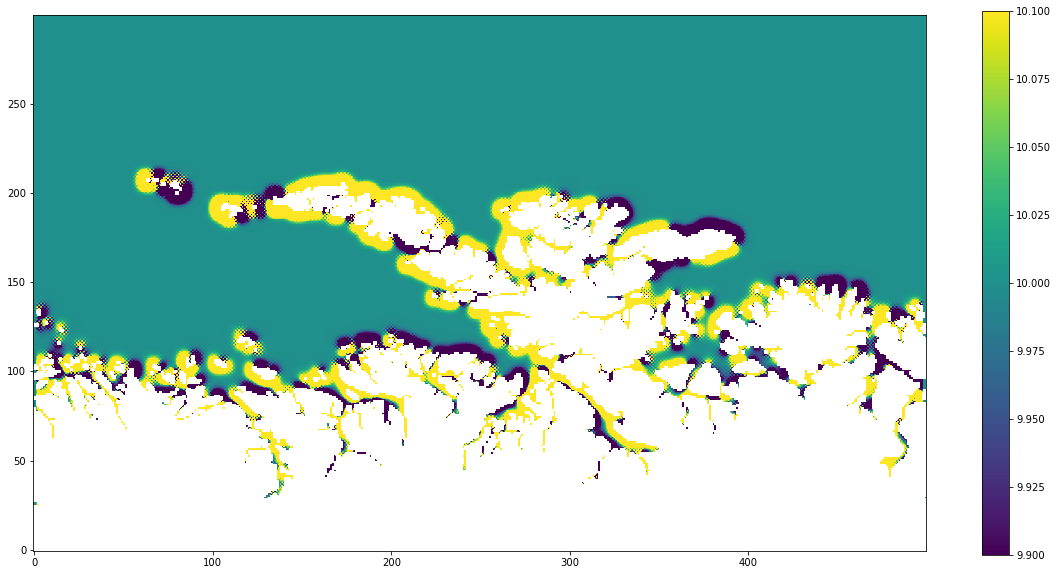

In [69]:
fig = plt.figure(figsize=(20, 10))
plt.imshow(h1, origin='lower', vmin=9.9, vmax=10.1)
plt.colorbar()

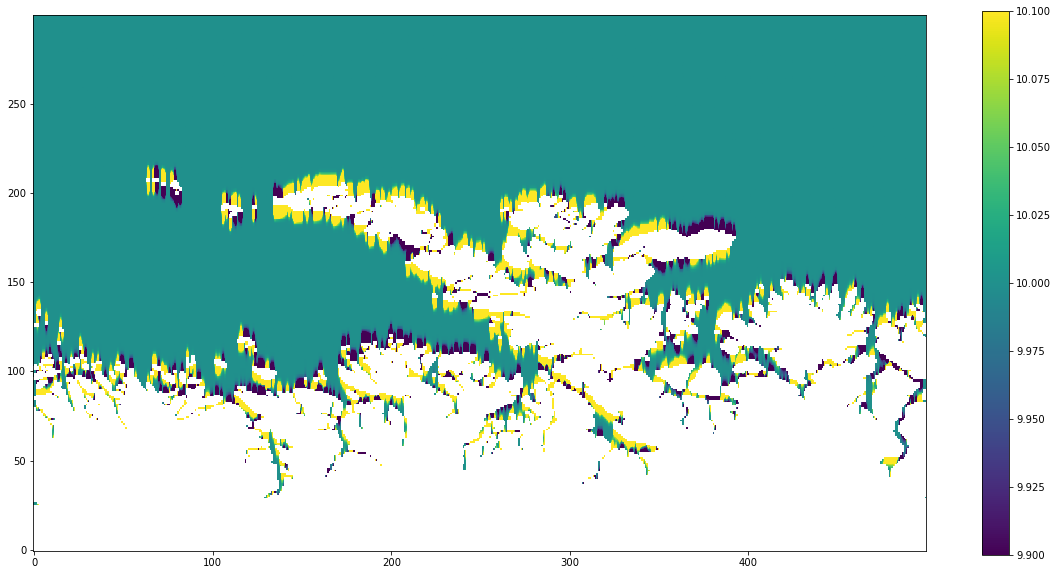

In [65]:
fig = plt.figure(figsize=(20, 10))
plt.imshow(h1, origin='lower', vmin=9.9, vmax=10.1)
plt.colorbar()

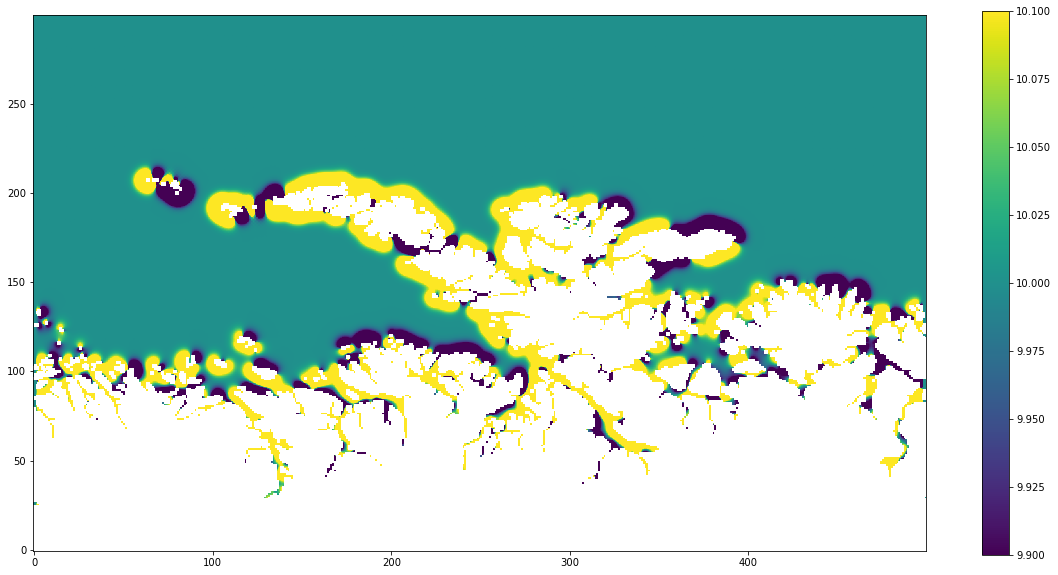

In [70]:
h1 = np.ones_like(h0)*10
for i in range(30):
    h1 = update_h(h1, u, v, f, 0.01, x_dir=True, y_dir=True)
    

fig = plt.figure(figsize=(20, 10))
plt.imshow(h1, origin='lower', vmin=9.9, vmax=10.1)
plt.colorbar()

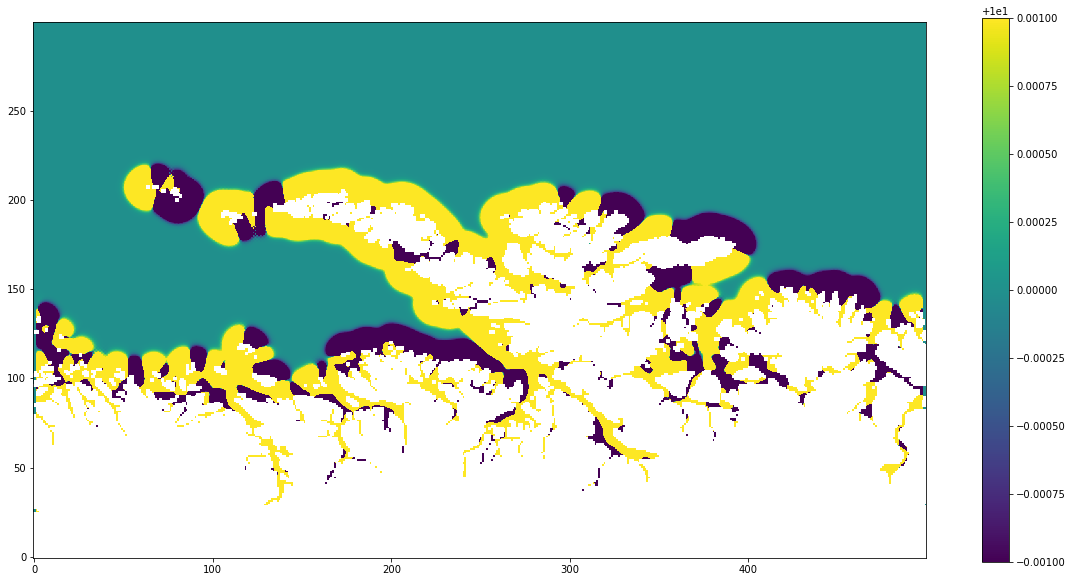

In [72]:

fig = plt.figure(figsize=(20, 10))
plt.imshow(h1, origin='lower', vmin=9.999, vmax=10.001)
plt.colorbar()

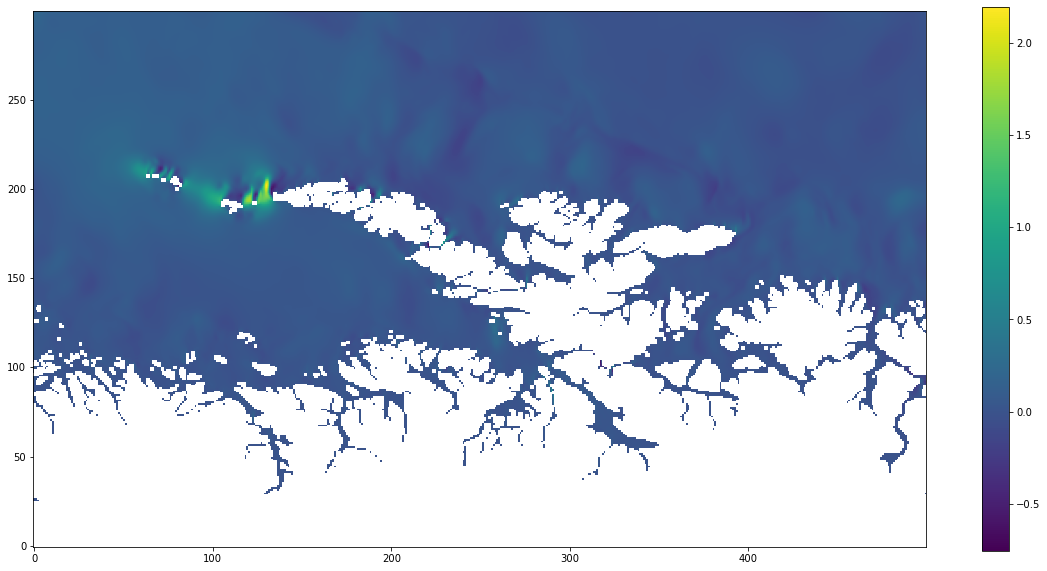

In [74]:
fig = plt.figure(figsize=(20, 10))
plt.imshow(v, origin='lower')
plt.colorbar()

In [ ]:
if "sim" in globals():
    sim.cleanUp()
    
sim = CDKLM16.CDKLM16(gpu_ctx, dt=0.0, write_netcdf=False,  **NetCDFInitialization.removeMetadata(data_args))
T = 24
anim_dt = 3600
sim_animation(sim, T, anim_dt, hu_max=50.0, eta_max=2, comment=case_info["name"])

C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\SWEsimulators\CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  jit_compile_args={
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


.........................

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


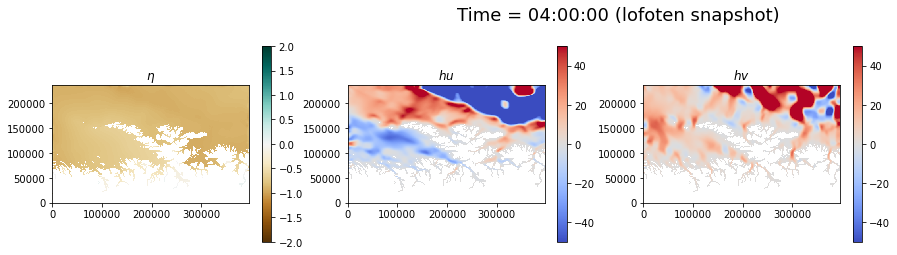

In [ ]:
if "sim" in globals():
    sim.cleanUp()
    
sim = CDKLM16.CDKLM16(gpu_ctx, dt=0.0, write_netcdf=False,  **NetCDFInitialization.removeMetadata(data_args))
sim.step(4*3600)
fig = plt.figure(figsize=(15,4))
_, _ = plotSolution(fig, sim, hu_max=50.0, eta_max=2, comment=case_info["name"]+" snapshot")
